<a href="https://colab.research.google.com/github/siddharth-iyer1/dsl_final_project_ai_vs_real_art/blob/main/Runtime/Runtime_CNN_Detect_AI_Artwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resizing the REAL and FAKE images to 256x256

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile
from PIL import Image

# Set the path to your zip file in the local session storage
zip_path = '/content/drive/MyDrive/Detect_AI_Art.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Set the paths to the "REAL" and "FAKE" folders
real_folder = '/content/REAL/'
fake_folder = '/content/FAKE/'

# Function to resize an image
def resize_image(image_path, output_path, size):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img.save(output_path)

# Create folders to store the resized images
os.makedirs('/content/REAL_resized', exist_ok=True)
os.makedirs('/content/FAKE_resized', exist_ok=True)

# Resize images in the "REAL" folder
for filename in os.listdir(real_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(real_folder, filename)
        output_path = os.path.join('/content/REAL_resized', filename)
        resize_image(image_path, output_path, (256, 256))

# Resize images in the "FAKE" folder
for filename in os.listdir(fake_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(fake_folder, filename)
        output_path = os.path.join('/content/FAKE_resized', filename)
        resize_image(image_path, output_path, (256, 256))

print("Image resizing completed.")

Image resizing completed.


Simple Convolutional Neural Network Architecture to Predict Real vs. AI Images


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import time
import matplotlib.pyplot as plt

subset_sizes = [200, 300, 400,500]


# Set the paths to the resized image folders
resized_folder = '/content/'

# Set the image size and batch size
img_size = (256, 256)
batch_size = 32

runtimes = []

for subset_size in subset_sizes:
    print(f"\nSubset size: {subset_size}")
    start_time = time.time()

    # Create data generators for training, validation, and testing
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators for train and validation sets
    train_generator = train_datagen.flow_from_directory(
        directory=resized_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        classes=['REAL_resized', 'FAKE_resized'],
        subset='training',
        shuffle=True,
        seed=42
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=resized_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        classes=['REAL_resized', 'FAKE_resized'],
        subset='validation',
        shuffle=True,
        seed=42
    )

    # Build the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model on a subset of the data
    train_steps = subset_size // batch_size
    validation_steps = int(subset_size * 0.2) // batch_size

    model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        epochs=10,
        verbose=0  # Set verbose to 0 to suppress output during training
    )

    # Evaluate the model on the test set
    test_generator = test_datagen.flow_from_directory(
        directory=resized_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        classes=['REAL_resized', 'FAKE_resized'],
        shuffle=False
    )

    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)
    print(f'Test accuracy: {test_acc:.4f}')

    end_time = time.time()
    runtime = end_time - start_time
    runtimes.append(runtime)
    print(f"Runtime for subset size {subset_size}: {runtime:.2f} seconds")




Subset size: 200
Found 2728 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.
Test accuracy: 0.8833
Runtime for subset size 200: 458.59 seconds

Subset size: 300
Found 2728 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.
Test accuracy: 0.9012
Runtime for subset size 300: 577.53 seconds

Subset size: 400
Found 2728 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.
Test accuracy: 0.9071
Runtime for subset size 400: 781.95 seconds

Subset size: 500
Found 2728 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.
Test accuracy: 0.9351
Runtime for subset size 500: 899.52 seconds


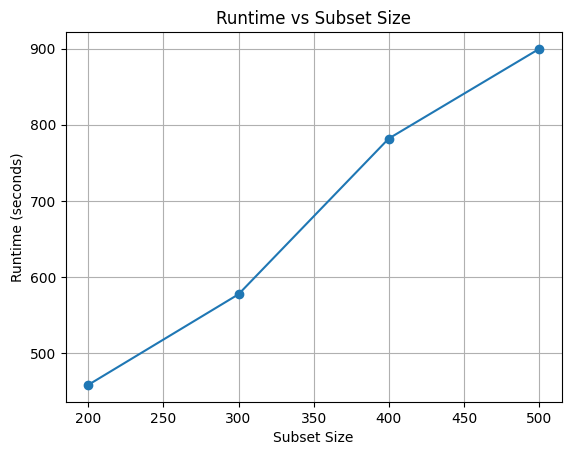

In [4]:
# Plot the runtimes
plt.plot(subset_sizes, runtimes, marker='o')
plt.title('Runtime vs Subset Size')
plt.xlabel('Subset Size')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.show()

In [ ]:
model.save("saved_model.pb")


In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow_model_optimization as tfmot
annotated_model = tfmot.quantization.keras.quantize_annotate_layer(model)


ValueError: `to_annotate` can only be a `keras.layers.Layer` instance. You passed an instance of type: Sequential.

In [ ]:

# Quantize the model
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

ValueError: `to_annotate` can only be a `keras.Model` instance. Use the `quantize_annotate_layer` API to handle individual layers. You passed an instance of type: Sequential.

In [ ]:
q_aware_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
q_aware_model.summary()
